# Senate vote position prediction using transductive learning

Predicting the positions of senators on a given bill, given its cosponsors.

## 1 Data preprocessing

In [118]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import ast
import scipy
from scipy import sparse
import networkx as nx
from lib import models_alt, graph, coarsening, utils
from pyunlocbox import functions, solvers

import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
VOTES_115 = '../data/all-votes/votes_115.csv'
BILLS_115 = '../data/bills_115.csv'
ADJACENCY = '../data/adjacency.csv'

In [63]:
all_bills = pd.read_csv(BILLS_115)
votes_115 = pd.read_csv(VOTES_115)
bills_sen = all_bills[all_bills.sponsor_title=='Sen.'] # bills sponsored by senators
N_BILLS_SEN = bills_sen.shape[0]

In [64]:
members_aux = pd.DataFrame(list(votes_115['member_id'].unique())).rename(columns={0: 'member_id'})
members = members_aux.merge(votes_115.drop_duplicates(subset = 'member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])
N_SENATORS = len(members)

In [65]:
for i,j in enumerate(bills_sen.cosponsors_sen):
    bills_sen.cosponsors_sen.iloc[i] = ast.literal_eval(j)

In [66]:
bills_sen.head()

,Unnamed: 0,bill_api_uri,date,democrats_no,democrats_yes,independent_no,independent_yes,month,republican_no,republican_yes,...,sponsor_id,sponsor_party,sponsor_title,result_ok,nb_cosponsors_R,nb_cosponsors_D,nb_cosponsors_I,cosponsors_sen,cosponsors_rep,cosponsors_del
1,1,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,16,30,1,1,1,0,50,...,M000303,R,Sen.,passed,0,0,0,[],[],[]
2,3,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
3,4,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,45,0,2,0,1,0,51,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
4,5,https://api.propublica.org/congress/v1/115/bil...,2017-01-12,0,45,0,2,1,49,2,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]
5,6,https://api.propublica.org/congress/v1/115/bil...,2017-01-11,44,1,2,0,1,0,51,...,E000285,R,Sen.,rejected,0,0,0,[],[],[]


Create binary matrices indicating sponsorship (and cosponsorship):

In [67]:
S = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    S[i, list(members['member_id']).index(bills_sen.sponsor_id.iloc[i])] = 1

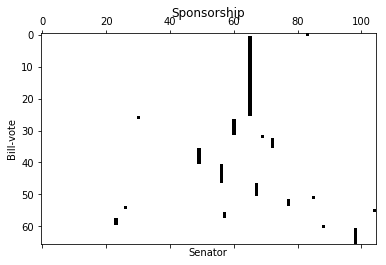

In [68]:
plt.spy(S)
plt.title('Sponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [69]:
CS = np.zeros((N_BILLS_SEN, N_SENATORS))
for i, j in enumerate(bills_sen.cosponsors_sen):
    for k, l in enumerate(bills_sen.cosponsors_sen.iloc[i]):
        CS[i, list(members['member_id']).index(bills_sen.cosponsors_sen.iloc[i][k])] = 1

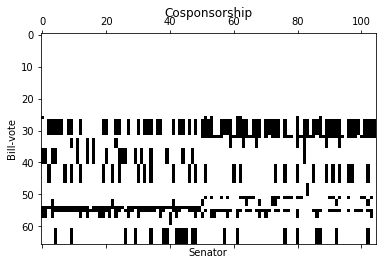

In [70]:
plt.spy(CS)
plt.title('Cosponsorship')
plt.xlabel('Senator')
plt.ylabel('Bill-vote');

In [71]:
Z = S + CS # sponsorship mask

In [72]:
def numeric_votes(x):
    if x == 'Yes':
        return 1
    elif x == 'Not Voting' or pd.isnull(x):
        return 0 # we can put np.nan and then fill with the median or mean, whatever for now
    else:
        return -1

Get all votes for each bill-vote:

In [73]:
Y=np.zeros((N_BILLS_SEN, N_SENATORS))

for i, l in enumerate(list(bills_sen.vote_uri)):
    votes = (members.merge(votes_115[votes_115.vote_uri == l], how='left'))
    feature = votes.vote_position.apply(numeric_votes).values
    Y[i] = feature

In [74]:
Y

array([[ 1., -1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [-1., -1., -1., ...,  1.,  1.,  1.],
       ...,
       [-1., -1., -1., ...,  1., -1., -1.],
       [-1., -1., -1., ...,  1., -1., -1.],
       [ 1.,  1.,  1., ...,  0.,  1.,  1.]])

Use as feature vector the voting profile for each senator:

In [75]:
X = 0*np.ones((N_BILLS_SEN, N_SENATORS))
X[Z==1]=Y[Z==1]

In [76]:
X.shape

(66, 105)

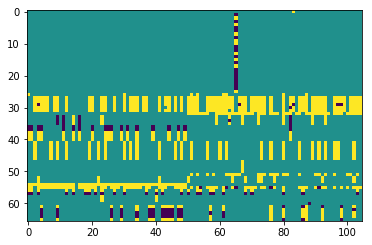

In [77]:
plt.imshow(X)

In [78]:
n = X.shape[0]
d = X.shape[1]

print('n = {}\nd = {}'.format(n, d))

n = 66
d = 105


In [79]:
n_train = n//2
n_val = n//10

perm_idx = np.random.permutation(n)
X_train = X[perm_idx[:n_train]]
X_val = X[perm_idx[n_train:n_train+n_val]]
X_test = X[perm_idx[n_train+n_val:]]

y_train = Y[perm_idx[:n_train]]
y_val = Y[perm_idx[n_train:n_train+n_val]]
y_test = Y[perm_idx[n_train+n_val:]]

In [189]:
#A = sparse.csr_matrix(np.genfromtxt(ADJACENCY, delimiter = ','), dtype = np.float32)
dist, idx = graph.distance_scipy_spatial(y_train.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

In [193]:
A = (A > 0.01).astype(np.float32)

d = |V| = 105, k|V| < |E| = 1460


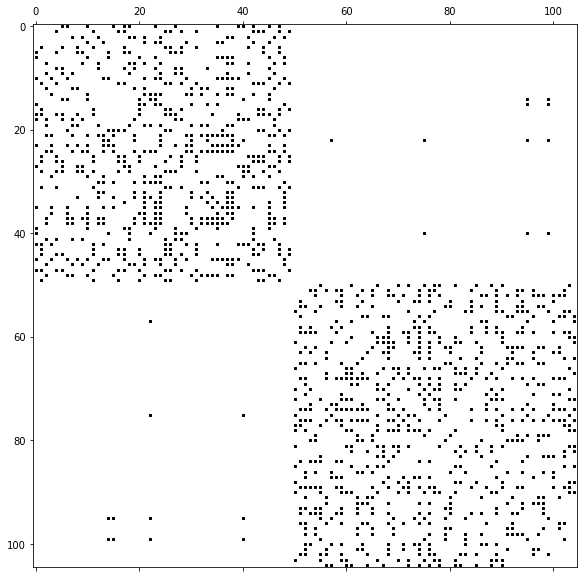

In [194]:
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
plt.figure(figsize=(10,10))
plt.spy(A, markersize=2, color='black');

In [195]:
L = [graph.laplacian(A, normalized=True) for z in range(2)]

(0, 1.4437379832418804)

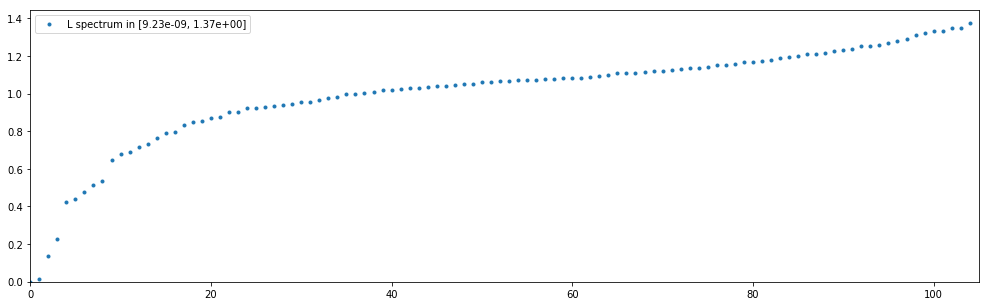

In [196]:
plt.figure(figsize=(17, 5))
lamb, U = np.linalg.eigh(L[0].toarray())
x = range(0, L[0].shape[0])
lb = 'L spectrum in [{:1.2e}, {:1.2e}]'.format(lamb[0], lamb[-1])
plt.plot(x, lamb, '.', label=lb)
plt.legend(loc='best')
plt.xlim(0, L[0].shape[0])
plt.ylim(ymin=0)

## 2 Transductive learning

In [696]:
def graph_pnorm_interpolation(gradient, P, w, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z, w, x0)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, 
                                **kwargs, verbosity='NONE')
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, 
                                **kwargs, verbosity='NONE')
        return problem['sol']
    else:
        return x0

In [697]:
def P(a, w, labels):
    mask_pos = np.where(w==1)
    b = a.copy()
    b[mask_pos] = labels[mask_pos]
    return b

In [698]:
# Computing the gradient (incident matrix)
incident = np.zeros((d, int(A.sum() // 2)))
edge_idx = 0
for i in range(d):
    for k in range(i):
        if A[i,k] == 1.0:
            incident[i,edge_idx] = 1
            incident[k,edge_idx] = -1
            edge_idx += 1

In [699]:
def predict_votes(known_votes, p=1.):
    # Mask showing which entries have data
    w = (known_votes != 0).astype(int)  
    sol_min = graph_pnorm_interpolation(sparse.csr_matrix(incident).T, P, w, 
                                        x0=known_votes.copy(), p=p)
    return sol_min

In [700]:
G = nx.from_numpy_matrix(A.todense())
coords = nx.spring_layout(G) # Force-directed layout.

def plot_predictions(known_votes, true_votes, pred_votes, G, coords):
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=known_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[0])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[0])
    ax[0].set_title('Known cosponsor votes')
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=true_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[1])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[1])
    ax[1].set_title('Final votes')
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=pred_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[2])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[2])
    ax[2].set_title('Predicted votes')

In [701]:
def rel_err(truth, preds):
    ''' 
    Calculates the relative error between the true labels and an estimate
    
    Args:
        truth: Ground truth signal
        preds: Estimated signal
    '''
    return np.linalg.norm(truth - preds, 2) / np.linalg.norm(truth, 2)

In [783]:
def compute_acc(truth, preds):
    valid_indices = np.where(np.any([truth==1, truth==-1], axis=0))
    return (truth[valid_indices] == preds[valid_indices]).sum() / len(valid_indices)

In [702]:
def binarize(preds, threshold):
    preds_bin = (preds > threshold).astype(int)
    preds_bin[preds_bin==0] = -1
    return preds_bin

In [703]:
def search_best_threshold(truth, preds):
    best_error = np.inf
    best_threshold = 0
    
    thresholds = np.linspace(-1, 1, 100000)
    for t in thresholds:
        preds_bin = binarize(preds, t)
        r_err = rel_err(truth, preds_bin)
        if r_err < best_error:
            best_threshold = t
            best_error = r_err
    return best_threshold

In [704]:
test_idx = 3

known_votes = X_test[test_idx]
true_votes = y_test[test_idx]

In [705]:
pred_votes = predict_votes(known_votes, p=1.)

Relative error: 0.43 for threshold 0.26761


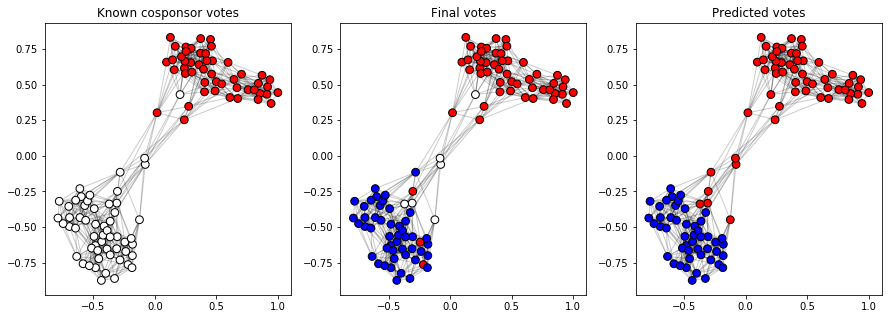

In [706]:
t = search_best_threshold(true_votes, pred_votes)
pred_votes_bin = binarize(pred_votes, t)
r_err = rel_err(true_votes, pred_votes_bin)
print('Relative error: {:.2f} for threshold {:.5f}'.format(r_err, t))
plot_predictions(known_votes, true_votes, pred_votes_bin, G, coords)

In [786]:
features = []
ts = []
errs = []
accs = []

for idx in range(X_train.shape[0]):
    known_votes = X_train[idx]
    true_votes = y_train[idx]
    
    pred_votes = predict_votes(known_votes, p=1.)
    
    t = search_best_threshold(true_votes, pred_votes)
    pred_votes_bin = binarize(pred_votes, t)
    r_err = rel_err(true_votes, pred_votes_bin)
    acc = compute_acc(true_votes, pred_votes_bin)
    
    dems_yay = (known_votes[:51] == 1).sum()
    dems_nay = (known_votes[:51] == -1).sum()
    reps_yay = (known_votes[51:] == 1).sum()
    reps_nay = (known_votes[51:] == -1).sum()
    no_dem_sponsors = (dems_yay + dems_nay == 0)
    no_rep_sponsors = (reps_yay + reps_nay == 0)
    dems_maj = (dems_yay + dems_nay > reps_yay + reps_nay)
    
    features.append([dems_yay, dems_nay, reps_yay, reps_nay, 
                     no_dem_sponsors, no_rep_sponsors, dems_maj])
    ts.append(t)
    errs.append(r_err)
    accs.append(acc)
    
features = np.array(features)
ts = np.array(ts)
errs = np.array(errs)
accs = np.array(accs)

In [787]:
accs.mean(), accs.std()

(92.84848484848484, 7.524188115353375)

In [788]:
errs.mean(), errs.std()

(0.47813977954307835, 0.2323331804063335)

In [789]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(criterion='mae')
rf.fit(features, ts)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [790]:
print(rf.feature_importances_)

[0.23946779 0.05803342 0.36685081 0.14696532 0.03569089 0.12112824
 0.03186351]


In [791]:
errs_test = []
accs_test = []

for idx in range(X_test.shape[0]):
    known_votes = X_test[idx]
    true_votes = y_test[idx]
    
    pred_votes = predict_votes(known_votes, p=1.)
    
    dems_yay = (known_votes[:51] == 1).sum()
    dems_nay = (known_votes[:51] == -1).sum()
    reps_yay = (known_votes[51:] == 1).sum()
    reps_nay = (known_votes[51:] == -1).sum()
    no_dem_sponsors = (dems_yay + dems_nay == 0)
    no_rep_sponsors = (reps_yay + reps_nay == 0)
    dems_maj = (dems_yay + dems_nay > reps_yay + reps_nay)
    f = np.array([dems_yay, dems_nay, reps_yay, reps_nay, 
                  no_dem_sponsors, no_rep_sponsors, dems_maj]).reshape(1,-1)
    t = rf.predict(f)
    
    pred_votes_bin = binarize(pred_votes, t)
    r_err = rel_err(true_votes, pred_votes_bin)
    acc = compute_acc(true_votes, pred_votes_bin)
    
    errs_test.append(r_err)
    accs_test.append(acc)

errs_test = np.array(errs_test)
accs_test = np.array(accs_test)

In [792]:
accs_test.mean(), accs_test.std()

(88.85185185185185, 11.420266922040165)

In [793]:
errs_test.mean(), errs_test.std()

(0.6069116083317233, 0.3033396392088346)

Relative error 0.85, accuracy 82.00 for threshold 0.71229


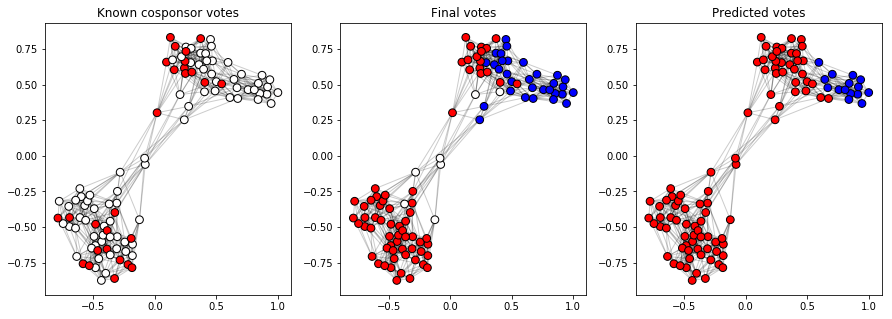

In [796]:
test_idx = 12
known_votes = X_test[test_idx]
true_votes = y_test[test_idx]

pred_votes = predict_votes(known_votes, p=1.)

dems_yay = (known_votes[:51] == 1).sum()
dems_nay = (known_votes[:51] == -1).sum()
reps_yay = (known_votes[51:] == 1).sum()
reps_nay = (known_votes[51:] == -1).sum()
no_dem_sponsors = (dems_yay + dems_nay == 0)
no_rep_sponsors = (reps_yay + reps_nay == 0)
dems_maj = (dems_yay + dems_nay > reps_yay + reps_nay)
f = np.array([dems_yay, dems_nay, reps_yay, reps_nay, 
              no_dem_sponsors, no_rep_sponsors, dems_maj]).reshape(1,-1)
t = float(rf.predict(f))

pred_votes_bin = binarize(pred_votes, t)
r_err = rel_err(true_votes, pred_votes_bin)
acc = acc = compute_acc(true_votes, pred_votes_bin)

print('Relative error {:.2f}, accuracy {:.2f} for threshold {:.5f}'.format(r_err, acc, t))
plot_predictions(known_votes, true_votes, pred_votes_bin, G, coords)